In [9]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_style("darkgrid")
# magic word for producing visualizations in notebook
%matplotlib inline

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [23]:
def build_model(pca_n=60, n_clusters=8):
    '''Creates a pipeline for doing KMeans clustering
    
    Args:
        pca_n (int): number of pca components
        n_clusters (int): number of clusters
    
    Returns:
        pipeline (sklearn.pipeline.Pipeline)
    '''
    pipeline = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(pca_n)),
            ('kmeans', KMeans(n_clusters=n_clusters, random_state=0))
    ])
    
    return pipeline

In [37]:
def print_interesting_features(features, components, i):
    '''Map weights for the principal component to corresponding feature names
    and then print the linked values, sorted by weight'''
    
    feature_weights = pd.DataFrame(index=azdias_clean.columns, data=model.named_steps['pca'].components_[i]).sort_values(by=0, ascending=False)
    feature_weights1 = pd.DataFrame(index=azdias_clean.columns, data=model.named_steps['pca'].components_[i]).sort_values(by=0)
    print('Highest:')
    for j in range(3):
        print('\t{:20} {:.3f}'.format(feature_weights.index[j], feature_weights[0][j]))
    print('Lowest:')
    for k in range(3):
        print('\t{:20} {:.3f}'.format(feature_weights1.index[k], feature_weights1[0][k]))

In [21]:
def plot_clusters(array1, array2):
    '''Plot clusters of two grouops
    Args:
        array1: predicion for azdias df
        array2: prediction for customers df
    Returns:
        bar plot
    '''
    unique1, counts1 = np.unique(array1, return_counts=True)
    df1 = pd.DataFrame(data=counts1, index=unique1)
    df1['proportion1'] = df1[0]/df1.sum()[0]
    
    unique2, counts2 = np.unique(array2, return_counts=True)
    df2 = pd.DataFrame(data=counts2, index=unique2)
    df2['proportion2'] = df2[0]/df2.sum()[0]
    
    df = pd.concat([df1['proportion1'], df2['proportion2']], axis=1)
    
    x = np.arange(1, n_clusters+1)  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,5))
    rects1 = ax.bar(x - width/2, df.proportion1, width, label='General')
    rects2 = ax.bar(x + width/2, df.proportion2, width, label='Customer')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Clusters')
    ax.set_xticks(x)
    ax.legend();

### Read data, build model, and plot clusters

Fill nulls:

1. numerical - mean
2. categorical - median

Cleaning data...

The critera for cleaning is:
1. remove columns have more than 20% nulls
2. remove row have more than 10% nulls
3. remove kba columns -- bias the dataset with minimum information
4. change the OST_WEST_KZ to dummy data
5. extract decade data from PRAEGENDE_JUGENDJAHRE
6. remove columns with too much dummy values (CAMEO_DEU_2015)
7. reengineer the mix datatype rows

In [7]:
azdias_clean = pd.read_csv('azdias_clean.csv')
customers_clean = pd.read_csv('customers_clean.csv')
azdias_clean.drop('Unnamed: 0', axis=1, inplace=True)
customers_clean.drop('Unnamed: 0', axis=1, inplace=True)

In [26]:
# Build model
pca_n = 60
n_clusters = 8

model = build_model(pca_n, n_clusters)

print('Fitting model...')
model.fit(azdias_clean)

print('Saving model...')
f = open('model' + str(n_clusters) + '.pkl', 'wb')
pickle.dump(model, f)

Fitting model...
Saving model...


In [27]:
# predict the model
az_prediction = model.predict(azdias_clean)
cus_prediction = model.predict(customers_clean)

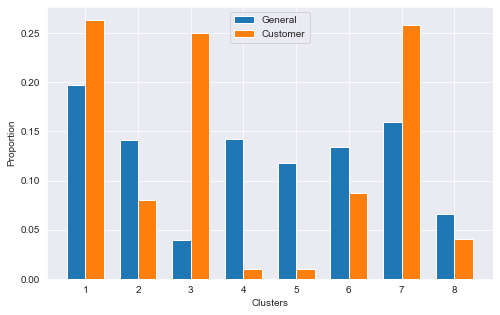

In [28]:
# plot the clusters
plot_clusters(az_prediction, cus_prediction)

We can see that in cluster **3 and 7**, the customers are **overrepresented**, and in cluster **4 and 5**, customers are **underrepresented**.

### Check princeple components

### Check the cluster center

In [35]:
(model.named_steps['kmeans'].cluster_centers_[4,:]).argmax(),(model.named_steps['kmeans'].cluster_centers_[4,:]).argmin()

(1, 2)

In [36]:
(model.named_steps['kmeans'].cluster_centers_[3,:]).argmax(),(model.named_steps['kmeans'].cluster_centers_[3,:]).argmin()

(1, 3)

In [42]:
for i in range(1, 4):
    print('PCA', i)
    print_interesting_features(azdias_clean.columns.values, model.named_steps['pca'].components_, i)
    print()

PCA 1
Highest:
	FINANZ_SPARER        0.244
	SEMIO_REL            0.212
	SEMIO_PFLICHT        0.211
Lowest:
	ALTERSKATEGORIE_GROB -0.222
	FINANZ_VORSORGER     -0.221
	FINANZ_MINIMALIST    -0.191

PCA 2
Highest:
	SEMIO_KAEM           0.199
	SEMIO_ERL            0.190
	ANREDE_KZ            0.172
Lowest:
	SEMIO_KULT           -0.203
	SEMIO_FAM            -0.185
	SEMIO_REL            -0.179

PCA 3
Highest:
	SEMIO_VERT           0.310
	SEMIO_SOZ            0.241
	SEMIO_FAM            0.212
Lowest:
	ANREDE_KZ            -0.330
	SEMIO_KAEM           -0.286
	SEMIO_DOM            -0.268



We can see that in the underrepresented clusters, the most positive compnents are PC1, and the most negative components are pc2 and pc3. 
We noticed that:
- PC1 is associated with finantial habbit and peronality (traditional minded etc.)
- PC2 and PC3 is associated with personality traits, community/family size.

This may indicate that finantial habbit (saving or not etc.) and personality can used to differentiate the customers.

In [39]:
(model.named_steps['kmeans'].cluster_centers_[2,:]).argmax(),(model.named_steps['kmeans'].cluster_centers_[2,:]).argmin()

(6, 7)

In [40]:
(model.named_steps['kmeans'].cluster_centers_[6,:]).argmax(),(model.named_steps['kmeans'].cluster_centers_[6,:]).argmin()

(0, 6)

In [43]:
for i in [0, 6, 7]:
    print('PCA', i)
    print_interesting_features(azdias_clean.columns.values, model.named_steps['pca'].components_, i)
    print()

PCA 0
Highest:
	D19_GESAMT_ANZ_24    0.198
	D19_GESAMT_ANZ_12    0.190
	D19_VERSAND_ANZ_24   0.182
Lowest:
	D19_GESAMT_DATUM     -0.194
	D19_VERSAND_DATUM    -0.186
	D19_GESAMT_ONLINE_DATUM -0.184

PCA 6
Highest:
	D19_BANKEN_ANZ_12    0.246
	D19_BANKEN_ANZ_24    0.236
	D19_TELKO_ANZ_12     0.216
Lowest:
	HEALTH_TYP           -0.287
	VERS_TYP             -0.261
	D19_BANKEN_DATUM     -0.211

PCA 7
Highest:
	HEALTH_TYP           0.373
	VERS_TYP             0.357
	NATIONALITAET_KZ     0.253
Lowest:
	D19_BANKEN_DATUM     -0.190
	D19_BANKEN_ONLINE_DATUM -0.187
	D19_VERSAND_ANZ_12   -0.172



We noticed that:
- PC0 is associated with transaction activities and online activities.
- PC6 is associated with online activities and health condition.
- PC7 is associated with health, insuarance, online transactions.

This indicated that transaction activities, insuarance and health may used to differentiate customers.

### Check original dataframe

In [44]:
azdias_clean['preds'] = az_prediction

In [45]:
customers_clean['preds'] = cus_prediction

In [78]:
# select columns to analyze
cols = ['TITEL_KZ', 'ANZ_TITEL', 'ANZ_HH_TITEL', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_GESAMT_ANZ_12', 
 'D19_GESAMT_ANZ_24', 'GREEN_AVANTGARDE', 'D19_BANKEN_ANZ_12', 'AGER_TYP', 'D19_TELKO_ANZ_12', 'D19_VERSI_ANZ_12',
'FINANZTYP', 'D19_VERSI_ANZ_24', 'GEBURTSJAHR', 'LP_FAMILIE_FEIN', 'D19_TELKO_ANZ_24', 'ALTER_HH','LP_FAMILIE_GROB',
'MOBI_REGIO', 'preds']
azdias_ana = azdias_clean.loc[:, cols]
customers_ana = customers_clean.loc[:, cols]

In [103]:
azdias_ana.groupby(['preds']).mean().T.loc[:,[3,4]].mean(axis=1)

TITEL_KZ                 0.000928
ANZ_TITEL                0.001539
ANZ_HH_TITEL             0.038714
D19_VERSAND_ANZ_12       0.331626
D19_VERSAND_ANZ_24       0.616545
D19_GESAMT_ANZ_12        0.432306
D19_GESAMT_ANZ_24        0.824457
GREEN_AVANTGARDE         0.127459
D19_BANKEN_ANZ_12        0.022356
AGER_TYP                -0.957492
D19_TELKO_ANZ_12         0.020596
D19_VERSI_ANZ_12         0.061497
FINANZTYP                2.512557
D19_VERSI_ANZ_24         0.128372
GEBURTSJAHR           1218.049605
LP_FAMILIE_FEIN          2.977001
D19_TELKO_ANZ_24         0.063288
ALTER_HH                11.783520
LP_FAMILIE_GROB          1.939471
MOBI_REGIO               2.482531
dtype: float64

In [104]:
customers_ana.groupby(['preds']).mean().T.loc[:,[2,6]].mean(axis=1)

TITEL_KZ                0.011444
ANZ_TITEL               0.012898
ANZ_HH_TITEL            0.016326
D19_VERSAND_ANZ_12      1.053892
D19_VERSAND_ANZ_24      1.530148
D19_GESAMT_ANZ_12       1.184961
D19_GESAMT_ANZ_24       1.703811
GREEN_AVANTGARDE        0.305262
D19_BANKEN_ANZ_12       0.035051
AGER_TYP               -0.155263
D19_TELKO_ANZ_12        0.033168
D19_VERSI_ANZ_12        0.114289
FINANZTYP               4.113657
D19_VERSI_ANZ_24        0.194824
GEBURTSJAHR           773.235242
LP_FAMILIE_FEIN         4.415750
D19_TELKO_ANZ_24        0.077507
ALTER_HH               12.609505
LP_FAMILIE_GROB         2.279254
MOBI_REGIO              4.040804
dtype: float64

We noticed that people with following characteristics is more likely to be customers for mail oder
1. Moving possibility is low 
2. Hold more and higher professional titles 
3. Higher transaction activities and total online/transaction activities
4. Older male
5. More likely to invest